In [1]:
import yfinance as yf
import os
import time
import requests

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from distfit import distfit


from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from pmdarima import auto_arima

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.base import BaseEstimator

from sklearn.metrics import mean_squared_error, mean_absolute_error


# Pre-procesamiento

In [2]:
data= pd.read_csv("qualitas_prices.csv", parse_dates=["Date"], index_col="Date")
print(data.shape)
display(data)

(2419, 7)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-07-17 00:00:00-05:00,21.103882,21.118946,20.712232,20.953247,34299,0.0,0.2
2015-07-20 00:00:00-05:00,20.719763,21.156603,20.712232,20.915588,79808,0.0,0.0
2015-07-21 00:00:00-05:00,20.938181,20.938181,20.719762,20.870396,59068,0.0,0.0
2015-07-22 00:00:00-05:00,20.877930,21.043628,20.712232,20.953247,378294,0.0,0.0
2015-07-23 00:00:00-05:00,20.877927,21.005967,20.712230,20.923119,145393,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-20 00:00:00-06:00,198.380005,198.380005,190.039993,193.000000,1340038,0.0,0.0
2025-02-21 00:00:00-06:00,193.919998,193.919998,186.059998,186.649994,1074466,0.0,0.0
2025-02-24 00:00:00-06:00,186.679993,196.479996,182.070007,196.330002,1076991,0.0,0.0


In [3]:
# Paso 1: Convertir el índice a datetime con utc=True para manejar tz-aware
data.index = pd.to_datetime(data.index, utc= True)

# Paso 2: Quitar huso horario
data.index = data.index.tz_localize(None)

# Paso 3: Normalizar fechas (eliminar horas, minutos y segundos)
data.index = data.index.normalize()

# Paso 4: Establecer frecuencia a días hábiles (usa "B" en mayúscula)
data= data.asfreq("B")

data = data.fillna(method= "bfill")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2509 entries, 2015-07-17 to 2025-02-26
Freq: B
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2509 non-null   float64
 1   High          2509 non-null   float64
 2   Low           2509 non-null   float64
 3   Close         2509 non-null   float64
 4   Volume        2509 non-null   float64
 5   Dividends     2509 non-null   float64
 6   Stock Splits  2509 non-null   float64
dtypes: float64(7)
memory usage: 156.8 KB


In [5]:
df= data["Close"]
display(df)

Date
2015-07-17     20.953247
2015-07-20     20.915588
2015-07-21     20.870396
2015-07-22     20.953247
2015-07-23     20.923119
                 ...    
2025-02-20    193.000000
2025-02-21    186.649994
2025-02-24    196.330002
2025-02-25    195.600006
2025-02-26    200.580002
Freq: B, Name: Close, Length: 2509, dtype: float64

# EDA

<function matplotlib.pyplot.show(close=None, block=None)>

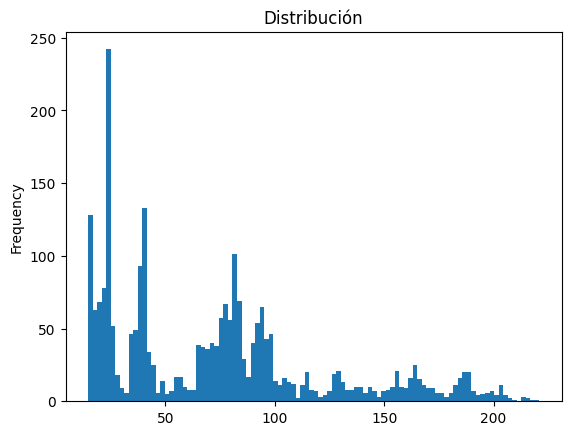

In [6]:
df.plot(kind="hist", bins=100)
plt.title("Distribución")
plt.show

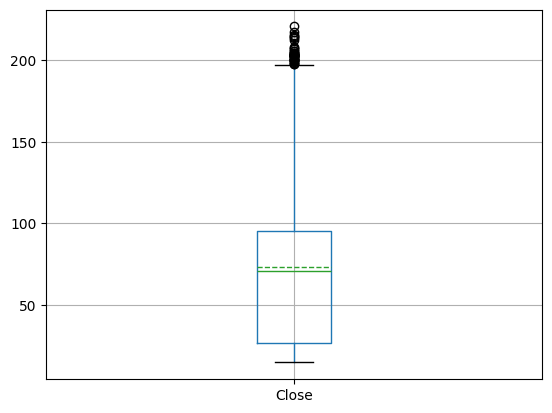

             Close
count  2509.000000
mean     73.465665
std      49.872168
min      14.656729
25%      26.884642
50%      70.548164
75%      95.094902
max     220.839996


In [7]:
df= df.to_frame()
df.boxplot(showmeans= True, meanline= True,)
plt.show()

print(df.describe())

## Validando que los precios de Q no son estacionarios

In [8]:
# Prueba Dickey-fuller
result= sts.adfuller(df)
print(f'p-valor: {result[1]}')

p-valor: 0.9886611373812665


Por lo anterio, no podemos rechazar la hipótesis nula (que no es estacionaria). Por lo tanto **no es estacionaria**.

## Transformación

In [9]:
df_transform= df.diff().dropna()
display(df_transform)

,Close
Date,
2015-07-20,-0.037659
2015-07-21,-0.045193
2015-07-22,0.082851
2015-07-23,-0.030128
2015-07-24,-0.045191
...,...
2025-02-20,-5.600006
2025-02-21,-6.350006
2025-02-24,9.680008


## Confirmar si la serie transformada es estacionaria.

Existen los casos en que una sola transformación no de una serie estacionaria.


In [10]:
# Prueba Dickey-fuller
result= sts.adfuller(df_transform)
print(f'p-valor: {result[1]}')

p-valor: 2.2278514075141216e-14


Dado que el p-valor es menor de 0.05 significa que rechazamos la hipótesis nula. Por lo tanto la serie es estacionaria

<function matplotlib.pyplot.show(close=None, block=None)>

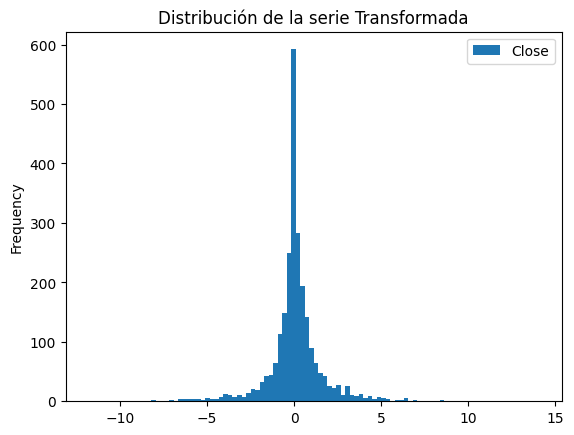

In [11]:
df_transform.plot(kind="hist", bins=100)
plt.title("Distribución de la serie Transformada")
plt.show

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [alpha          ] [0.08 sec] [RSS: 1.36123] [loc=-39.302 scale=836.778]
[distfit] >INFO> [anglit         ] [0.01 sec] [RSS: 2.34062] [loc=1.119 scale=16.489]
[distfit] >INFO> [arcsine        ] [0.05 sec] [RSS: 2.87807] [loc=-11.817 scale=25.883]
[distfit] >INFO> [beta           ] [0.12 sec] [RSS: 1.30873] [loc=-570.906 scale=1307.470]
[distfit] >INFO> [betaprime      ] [0.23 sec] [RSS: 1.30888] [loc=-189.659 scale=416.868]
[distfit] >INFO> [bradford       ] [0.03 sec] [RSS: 2.58496] [loc=-11.817 scale=25.877]
[distfit] >INFO> [burr           ] [0.34 sec] [RSS: 1.77352] [loc=-6190.968 scale=6166.849]
[distfit] >INFO> [cauchy         ] [0.00 sec] [RSS: 0.276146] [loc=0.021 scale=0.441]
[distfit] >INFO> [chi            ] [0.10 sec] [RSS: 1.31181] [loc=-42.464 scale=2.505]
[distfit] >INFO> [chi2           ] [0.12 sec] [RSS: 6.09855] [loc=-11.817 scale=1.576]
[distfit] >INFO> [cosine         ] [0.02 sec] [RSS: 2.20996] [loc=1.

KS-test p-valor: 0.0074


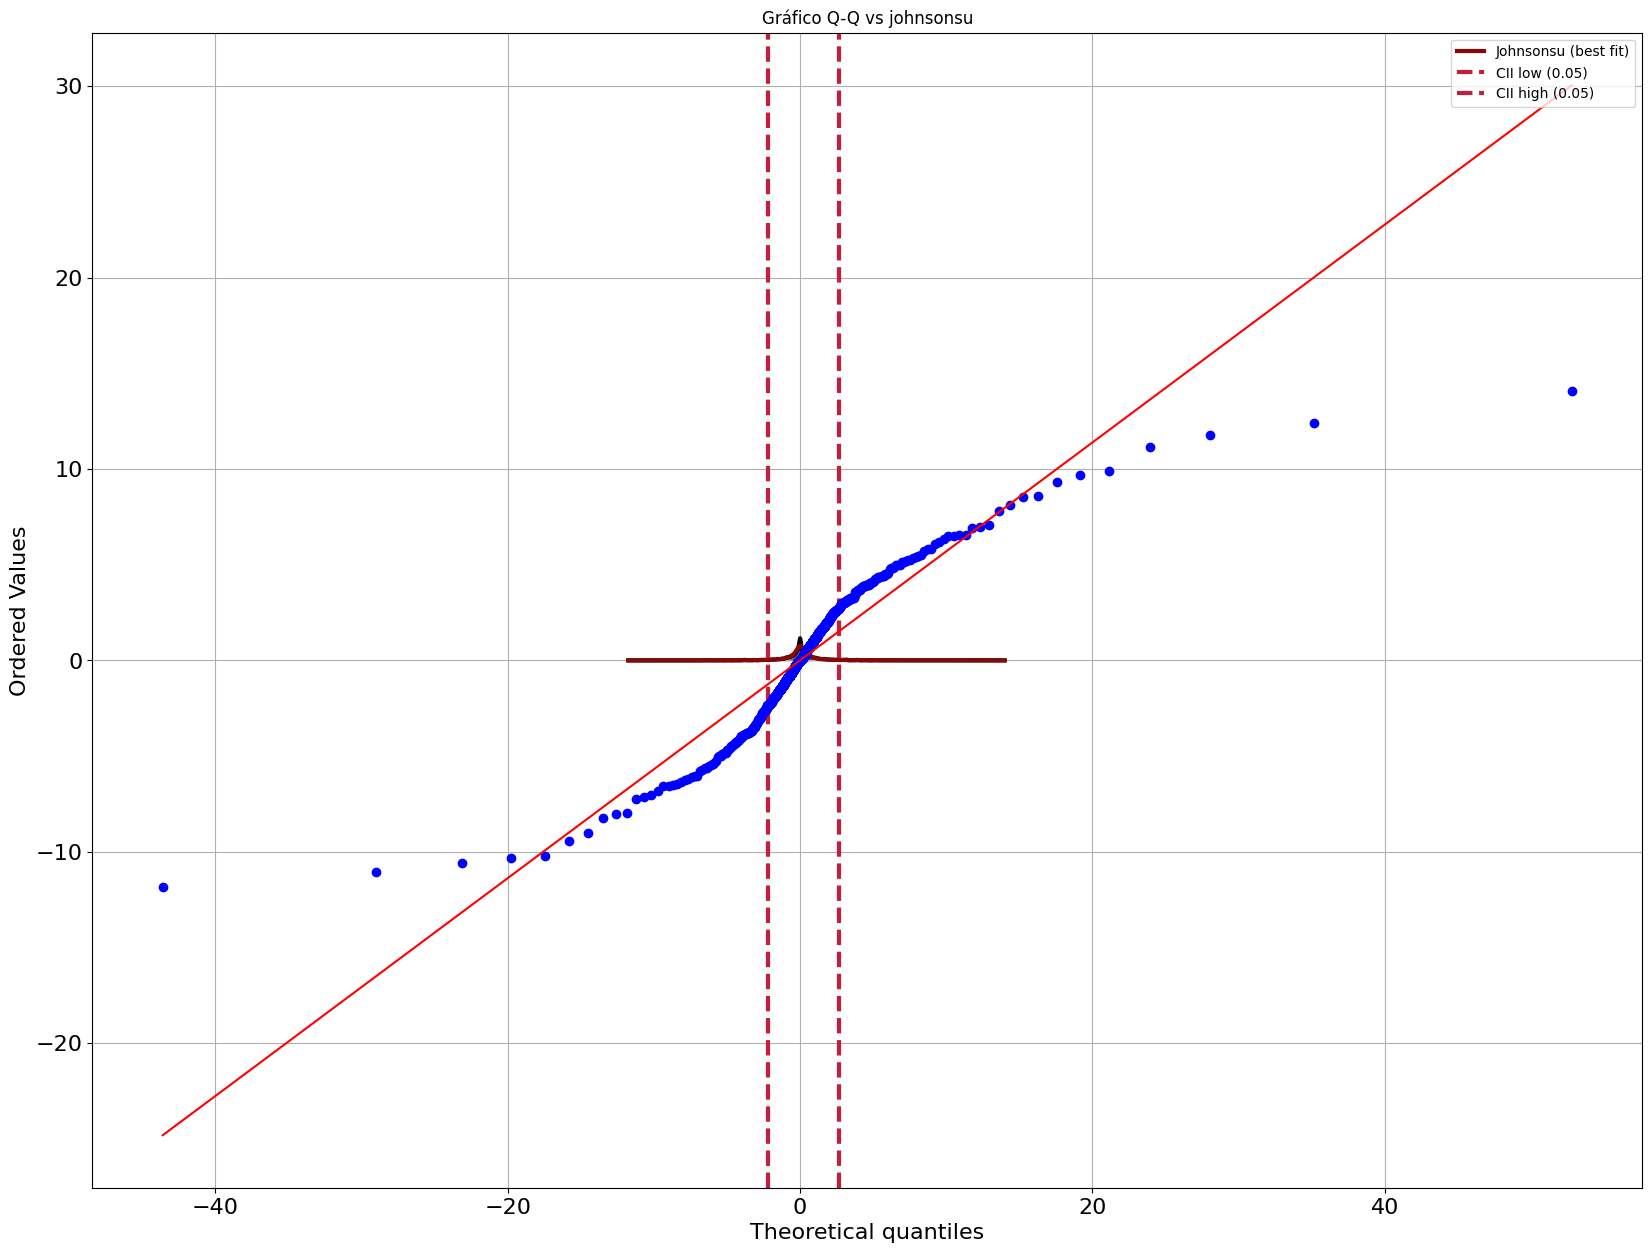

In [12]:
# Paso 1: Identificación automática con distfit
dfit = distfit(distr="full")  # 'full' para todas las distribuciones
dfit.fit_transform(df_transform["Close"])
dfit.plot()

# Paso 2: Validación con KS-test para la mejor distribución
best_dist_name = dfit.model["name"]
best_params = dfit.model["params"]
D, p_value = stats.kstest(df_transform["Close"], best_dist_name, args=best_params)
print(f"KS-test p-valor: {p_value:.4f}")

# Paso 3: Gráfico Q-Q para diagnóstico visual
stats.probplot(df_transform["Close"], dist=best_dist_name, sparams=best_params, plot=plt)
plt.title(f"Gráfico Q-Q vs {best_dist_name}")
plt.show()

## Distribución Parsimoniosa

In [13]:
# Parámetros obtenidos previamente con distfit
best_dist_name = "johnsonsu"
best_params = dfit.model["params"]  # (loc, scale, a, b) en scipy

from scipy.stats import johnsonsu

# Calcular log-verosimilitud
log_lik_johnson = np.sum(johnsonsu.logpdf(df_transform["Close"], 
                                        best_params[2],  # Parámetro "a"
                                        best_params[3],  # Parámetro "b"
                                        loc=best_params[0], 
                                        scale=best_params[1]))

# Calcular AIC (4 parámetros: a, b, loc, scale)
k_johnson = 4
aic_johnson = 2 * k_johnson - 2 * log_lik_johnson
print(f"AIC para Johnson SU: {aic_johnson:.2f}")

AIC para Johnson SU: 10733.06


In [14]:
from scipy.stats import t, skewnorm, laplace, norm

def calculate_aic(data, dist_name, params):
    log_lik = eval(f"np.sum({dist_name}.logpdf(data, *params))")
    k = len(params)
    return 2*k - 2*log_lik

# Comparar AIC para varias distribuciones
distribuciones = ["norm", "t", "laplace", "skewnorm"]

for dist_name in distribuciones:
    params = eval(f"stats.{dist_name}.fit(df_transform['Close'])")
    aic = calculate_aic(df_transform["Close"], f"stats.{dist_name}", params)
    print(f"AIC para {dist_name}: {aic:.2f}")

AIC para norm: 9970.67
AIC para t: 8150.45
AIC para laplace: 8435.58
AIC para skewnorm: 9952.12


#### ¿Por qué la t de Student es mejor aquí?

1. Captura colas pesadas: Los rendimientos financieros suelen tener colas más gruesas que una normal, y la t de Student modela esto con solo 3 parámetros (grados de libertad, loc, scale).

2. Parsimonia: Johnson SU, aunque flexible, tiene 4 parámetros y su complejidad no justifica el peor AIC.

3. Evidencia empírica: La t de Student es ampliamente utilizada en finanzas para rendimientos, precisamente por su capacidad para modelar colas pesadas sin sobreajustar.

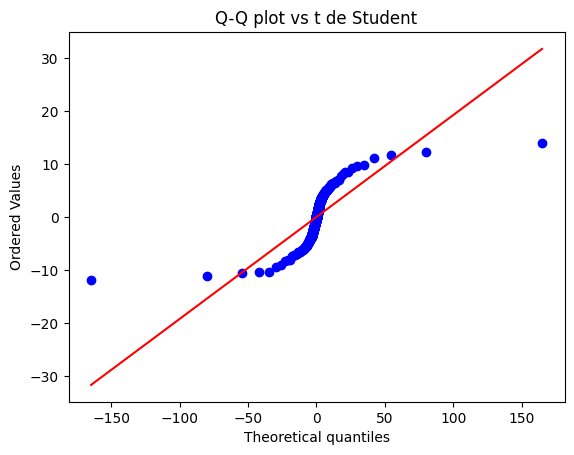

In [15]:
params_t = stats.t.fit(df_transform["Close"])
stats.probplot(df_transform["Close"], dist="t", sparams=params_t, plot=plt)
plt.title("Q-Q plot vs t de Student")
plt.show()

- La t de Student es la mejor opción según el AIC, pero el Q-Q revela que:

    - Las colas pesadas de tus datos son más extremas de lo que la t estándar puede capturar.

    - Existe posible asimetría en los rendimientos.

- Solución práctica: Usa la t de Student con grados de libertad estimados desde los datos y complementa con análisis de sensibilidad para eventos extremos.

# Modelo Auto_ARIMA

## Tenemos estacionalidad? Pendiente

Al parecer no hay estacionalidad

<Figure size 1200x600 with 0 Axes>

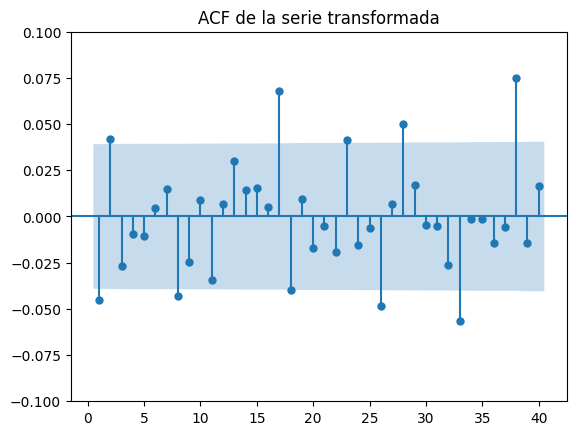

In [16]:
# Graficar ACF y PACF
plt.figure(figsize=(12, 6))
sgt.plot_acf(df_transform["Close"], lags=40, zero= False)  # Analiza hasta 40 lags (8 semanas hábiles)
plt.title("ACF de la serie transformada")
plt.ylim((-0.1, 0.1))
plt.show()

<Figure size 1200x600 with 0 Axes>

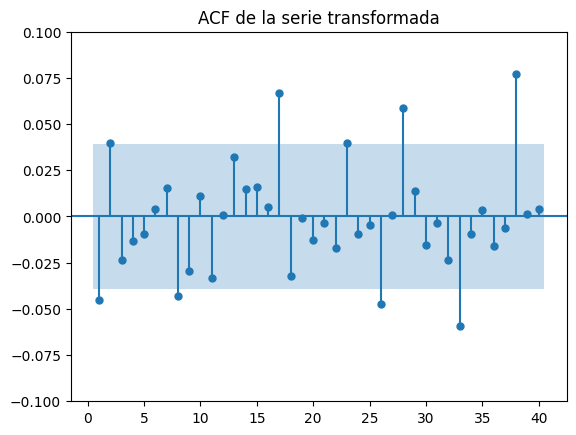

In [17]:
plt.figure(figsize=(12, 6))
sgt.plot_pacf(df_transform["Close"], lags=40, zero= False)  # Analiza hasta 40 lags (8 semanas hábiles)
plt.title("ACF de la serie transformada")
plt.ylim((-0.1, 0.1))
plt.show()

In [18]:
size = int(len(df_transform) * 0.85)
trans_train = df_transform.iloc[:size]
trans_test = df_transform.iloc[size:]

In [19]:
model_auto= auto_arima(trans_train, d=0)

In [20]:
model_auto

ARIMA(order=(3, 0, 2), scoring_args={}, suppress_warnings=True)

In [21]:
pred_trans= model_auto.predict(n_periods= len(trans_test))
mse_transformed = mean_squared_error(trans_test, pred_trans)
rmse_transformed = np.sqrt(mse_transformed)

print(f'MSE: {mse_transformed}')
print(f'RMSE: {rmse_transformed}')

trans_auto_predict= pd.DataFrame(pred_trans)
display(trans_auto_predict)

MSE: 13.780153070707117
RMSE: 3.7121628561671587


,0
2023-09-19,-0.200357
2023-09-20,0.168292
2023-09-21,0.225420
2023-09-22,-0.251030
2023-09-25,0.253159
...,...
2025-02-20,0.051517
2025-02-21,0.051517
2025-02-24,0.051517
2025-02-25,0.051517


In [22]:
df_test= df.loc["2023-09-19":"2025-02-26"]
display(df_test)

,Close
Date,
2023-09-19,133.447556
2023-09-20,134.322525
2023-09-21,131.053406
2023-09-22,134.601379
2023-09-25,127.755432
...,...
2025-02-20,193.000000
2025-02-21,186.649994
2025-02-24,196.330002


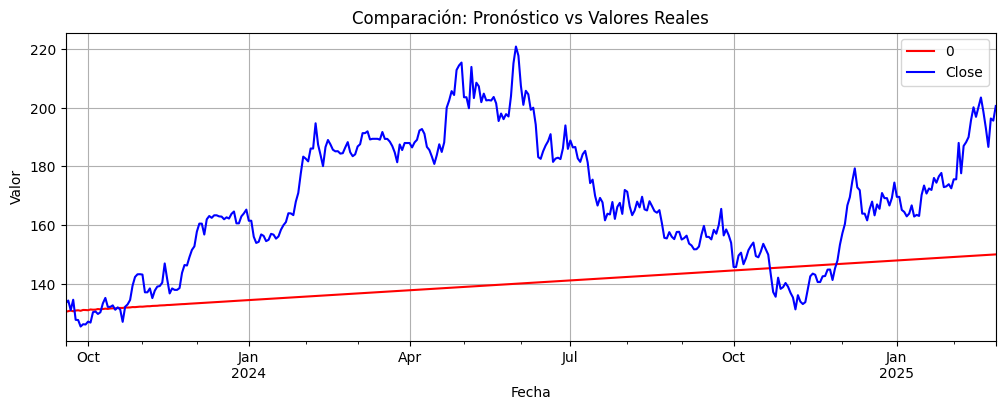

In [23]:
df_forcast= df.loc["2023-09-18", "Close"] + trans_auto_predict.cumsum()

plt.figure(figsize=(12, 4))

# Graficar ambas series en los mismos ejes
ax = plt.gca()  # Obtener los ejes actuales
df_forcast.plot(color="red", label="Pronóstico", ax=ax)
df_test.plot(color="blue", label="Reales", ax=ax)

# Añadir leyenda y título
plt.legend()
plt.title("Comparación: Pronóstico vs Valores Reales")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.grid(True)
plt.show()

In [24]:
mse_arima = mean_squared_error(df_test, df_forcast)
rmse_arima = np.sqrt(mse_arima)

print(f'MSE: {mse_arima}')
print(f'RMSE: {rmse_arima}')

print(model_auto.summary())

MSE: 1213.1003597259578
RMSE: 34.82959028937834
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2131
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -3219.578
Date:                Sat, 22 Mar 2025   AIC                           6453.157
Time:                        20:12:16   BIC                           6492.807
Sample:                    07-20-2015   HQIC                          6467.669
                         - 09-18-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1456      0.071      2.065      0.039       0.007       0.284
ar.L1         -1.0985      0.038    -29.132      0.000      -1.172      -1.025
ar.L

Conclusión:

Al comparar los datos originales con los datos transformados el RMSE se nos disparo bastante dejando el valor de RMSE: 34.82959028937834 con respecto a los datos transformados RMSE: 3.7121628561671587


# Prophet

In [25]:
p_train= trans_train.copy()
p_test = trans_test.copy()

p_train = p_train.reset_index()
p_test = p_test.reset_index()

p_train.columns= ["ds", "y"]
p_test.columns= ["ds", "y"]

p_train["ds"]= pd.to_datetime(p_train["ds"])
p_test["ds"]= pd.to_datetime(p_test["ds"])


In [26]:
display(p_train)
print(p_train.info())

,ds,y
0,2015-07-20,-0.037659
1,2015-07-21,-0.045193
2,2015-07-22,0.082851
3,2015-07-23,-0.030128
4,2015-07-24,-0.045191
...,...,...
2126,2023-09-12,1.057663
2127,2023-09-13,0.461517
2128,2023-09-14,0.413452
2129,2023-09-15,-0.538452


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2131 entries, 0 to 2130
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2131 non-null   datetime64[ns]
 1   y       2131 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 33.4 KB
None


[distfit] >DEBUG> cmd: where.exe tbb.dll
cwd: None
[distfit] >DEBUG> Adding TBB (c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
[distfit] >INFO> Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[distfit] >DEBUG> input tempfile: C:\Users\snede\AppData\Local\Temp\tmpoywt2l0q\1imauz4e.json
[distfit] >DEBUG> input tempfile: C:\Users\snede\AppData\Local\Temp\tmpoywt2l0q\pn2osfft.json
[distfit] >DEBUG> idx 0
[distfit] >DEBUG> running CmdStan, num_threads: None
[distfit] >DEBUG> CmdStan args: ['C:\\Users\\snede\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=69535', 'data', 'file=C:\\Users\\snede\\AppData\\Local\\Temp\\tmpoywt2l0q\\1imauz4e.json', 'init=C:\\Users\\snede\\AppData\\Local\\Temp\\tmpoywt2l0q\\pn2osfft.json', 'output', 'file=C:\\Users\\snede\\AppData\\Local\\Temp\\tmpoywt2l0q

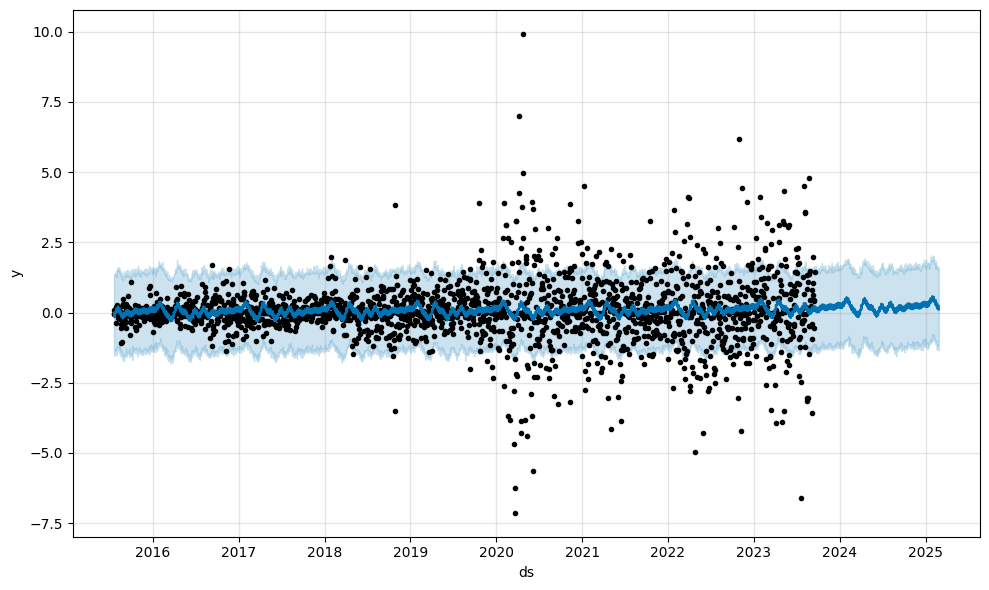

In [27]:
m=Prophet()
m.fit(p_train)
future= m.make_future_dataframe(len(trans_test), freq= "B")
forecast= m.predict(future)
fig=m.plot(forecast)

In [28]:
display(forecast)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-07-20,-0.006639,-1.498329,1.294882,-0.006639,-0.006639,-0.122232,-0.122232,-0.122232,-0.009634,-0.009634,-0.009634,-0.112598,-0.112598,-0.112598,0.0,0.0,0.0,-0.128871
1,2015-07-21,-0.006606,-1.539633,1.295408,-0.006606,-0.006606,-0.145230,-0.145230,-0.145230,-0.043431,-0.043431,-0.043431,-0.101799,-0.101799,-0.101799,0.0,0.0,0.0,-0.151837
2,2015-07-22,-0.006573,-1.316482,1.392444,-0.006573,-0.006573,0.025263,0.025263,0.025263,0.113970,0.113970,0.113970,-0.088707,-0.088707,-0.088707,0.0,0.0,0.0,0.018690
3,2015-07-23,-0.006541,-1.465534,1.345259,-0.006541,-0.006541,-0.135512,-0.135512,-0.135512,-0.061879,-0.061879,-0.061879,-0.073633,-0.073633,-0.073633,0.0,0.0,0.0,-0.142052
4,2015-07-24,-0.006508,-1.384598,1.384511,-0.006508,-0.006508,-0.024970,-0.024970,-0.024970,0.031972,0.031972,0.031972,-0.056943,-0.056943,-0.056943,0.0,0.0,0.0,-0.031478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503,2025-02-20,0.192282,-1.318435,1.618630,0.188703,0.195741,-0.053349,-0.053349,-0.053349,-0.061879,-0.061879,-0.061879,0.008530,0.008530,0.008530,0.0,0.0,0.0,0.138933
2504,2025-02-21,0.192390,-1.152182,1.597409,0.188773,0.195855,0.026266,0.026266,0.026266,0.031972,0.031972,0.031972,-0.005707,-0.005707,-0.005707,0.0,0.0,0.0,0.218656
2505,2025-02-24,0.192714,-1.262616,1.513188,0.189063,0.196186,-0.052939,-0.052939,-0.052939,-0.009634,-0.009634,-0.009634,-0.043305,-0.043305,-0.043305,0.0,0.0,0.0,0.139775
2506,2025-02-25,0.192822,-1.345382,1.626329,0.189150,0.196300,-0.097813,-0.097813,-0.097813,-0.043431,-0.043431,-0.043431,-0.054382,-0.054382,-0.054382,0.0,0.0,0.0,0.095009


In [29]:
predicted_prophet= forecast[forecast["ds"] >= "2023-09-19"]["yhat"]

display(predicted_prophet)


2131    0.066560
2132    0.217870
2133    0.035448
2134    0.122513
2135    0.061909
          ...   
2503    0.138933
2504    0.218656
2505    0.139775
2506    0.095009
2507    0.241988
Name: yhat, Length: 377, dtype: float64

In [30]:
df_p= df.loc["2023-09-18", "Close"] + predicted_prophet.cumsum()
df_p.index= df_test.index
display(df_p)


Date
2023-09-19    130.793062
2023-09-20    131.010932
2023-09-21    131.046380
2023-09-22    131.168893
2023-09-25    131.230801
                 ...    
2025-02-20    201.092222
2025-02-21    201.310878
2025-02-24    201.450653
2025-02-25    201.545662
2025-02-26    201.787650
Freq: B, Name: yhat, Length: 377, dtype: float64

MSE: 632.2018130606334
RMSE: 25.14362370583511


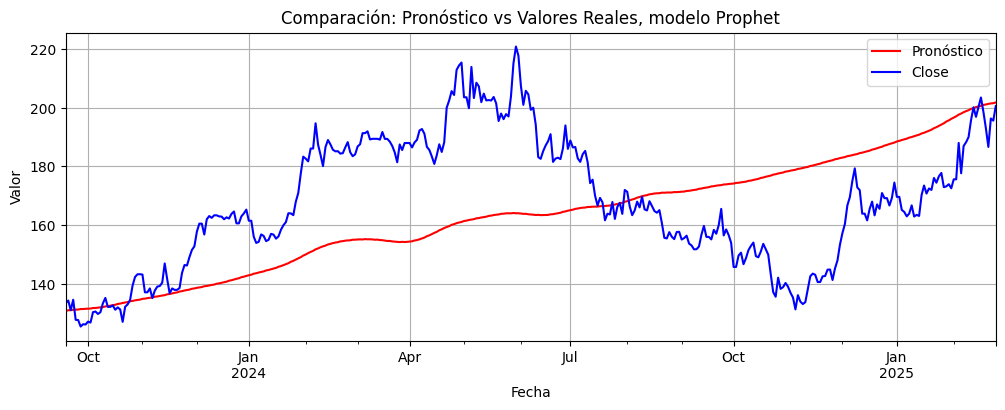

In [31]:
mse_p = mean_squared_error(df_test, df_p)
rmse_p = np.sqrt(mse_p)

print(f'MSE: {mse_p}')
print(f'RMSE: {rmse_p}')

plt.figure(figsize=(12, 4))

# Graficar ambas series en los mismos ejes
ax = plt.gca()  # Obtener los ejes actuales
df_p.plot(color="red", label="Pronóstico", ax=ax)
df_test.plot(color="blue", label="Reales", ax=ax)

# Añadir leyenda y título
plt.legend()
plt.title("Comparación: Pronóstico vs Valores Reales, modelo Prophet")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.grid(True)
plt.show()

**Conclusión**

Nuestro modelo Prophet tiene mejor rendimiento que ARIMA.

# Deep Learning

## Redes Neuronales Recurrentes RNN

In [32]:
import numpy as np
import tensorflow as tf
import random
import os

# Fijar la semilla para reproducibilidad
seed = 42
random.seed(seed)                      # Python
np.random.seed(seed)                   # NumPy
tf.random.set_seed(seed)               # TensorFlow

# Asegurar reproducibilidad en TensorFlow
os.environ['PYTHONHASHSEED'] = str(seed)

In [33]:
display(df)

,Close
Date,
2015-07-17,20.953247
2015-07-20,20.915588
2015-07-21,20.870396
2015-07-22,20.953247
2015-07-23,20.923119
...,...
2025-02-20,193.000000
2025-02-21,186.649994
2025-02-24,196.330002


<Axes: xlabel='Date'>

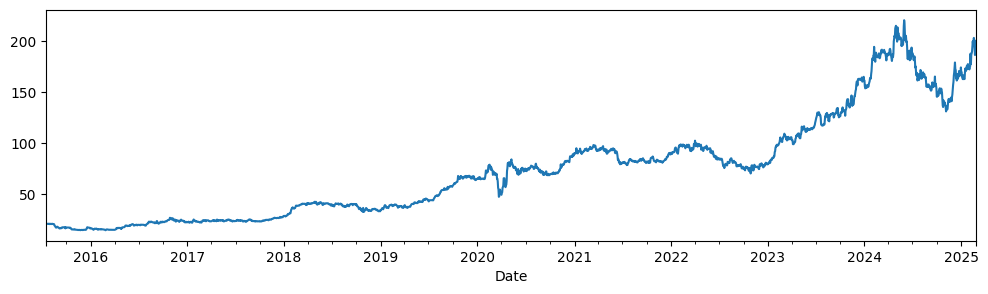

In [34]:
componentes = seasonal_decompose(df["Close"])
componentes.observed.plot(figsize=(12,3))

<Axes: xlabel='Date'>

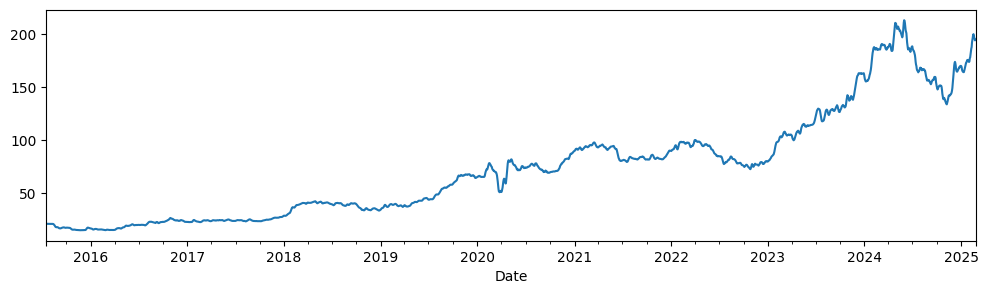

In [35]:
componentes.trend.plot(figsize= (12,3))

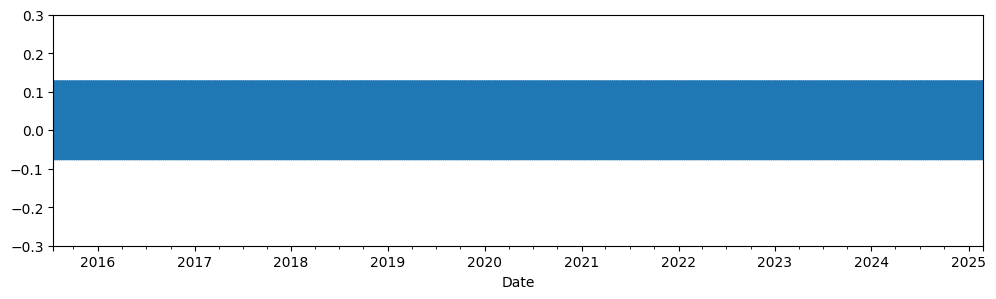

In [36]:
componentes.seasonal.plot(figsize=(12,3))
plt.ylim((-0.3, 0.3))
plt.show()

<Axes: xlabel='Date'>

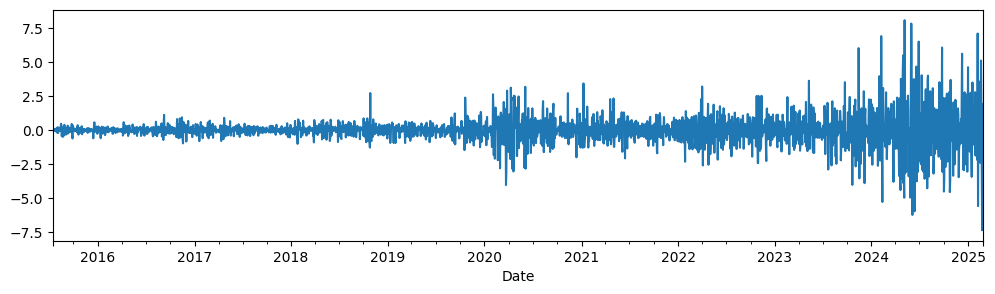

In [37]:
componentes.resid.plot(figsize=(12,3))


Analizando la composición de la serie:
* Estacionalidad: Carece de estacionalidad dado que su gráfica es una barra horizontal, no fluctuaciones relacionadas con el periodo de tiempo.
* Residuo: Es ruido blanco, ya se aplico la prueba de  Ljung-Box en otro proyecto.

In [38]:
size = int(len(df) * 0.85)
precios_train = df.iloc[:size]
precios_test = df.iloc[size:]


In [39]:
display(precios_train)
print(precios_test.shape)

,Close
Date,
2015-07-17,20.953247
2015-07-20,20.915588
2015-07-21,20.870396
2015-07-22,20.953247
2015-07-23,20.923119
...,...
2023-09-12,128.938095
2023-09-13,129.399612
2023-09-14,129.813065


(377, 1)


## Escalando los datos

Analiza la distribución:
Si el 95% de los datos están por debajo de 200 y solo un 5% están en 200-221, el impacto de los outliers es manejable. Si el 20% están en ese rango, considera reentrenar el modelo con RobustScaler.

Prueba ambos enfoques:
Entrena el modelo LSTM con MinMaxScaler y RobustScaler, y compara su rendimiento (ej. usando métricas como RMSE o MAE).

In [40]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(precios_train)

scaled_precios_train= scaler.transform(precios_train)
scaled_precios_test = scaler.transform(precios_test)

In [41]:
display(scaled_precios_train)

array([[0.0542477 ],
       [0.05392325],
       [0.05353389],
       ...,
       [0.99213028],
       [0.98749124],
       [1.        ]])

## Time Series Generator

In [42]:
import tensorflow as tf

In [43]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])  # Ajusta según tu problema
    return np.array(X), np.array(y)

# Ejemplo de uso:
sequence_length = 20  # Ventana temporal de un mes(días hábiles)
X_train, y_train = create_sequences(scaled_precios_train, sequence_length)
X_test, y_test = create_sequences(scaled_precios_test, sequence_length)

print(len(X_train))
print(len(y_train))



2112
2112


## Creando el modelo LSTM

In [44]:
from tensorflow.keras.layers import LSTM


In [45]:
print("Forma de X_train:", X_train.shape)  # Debe ser (2112, 20, 1)
print("-"*50)
print("Forma de X_test:", X_test.shape)  # Debe ser (357, 20, 1)


Forma de X_train: (2112, 20, 1)
--------------------------------------------------
Forma de X_test: (357, 20, 1)


In [46]:
# Crear el modelo
model = Sequential()

# Capa LSTM
model.add(LSTM(
    100, 
    activation='relu', 
    input_shape=(X_train.shape[1], X_train.shape[2])  # (20, 1)
))

# Dropout para evitar overfitting
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(1))

# Compilar
model.compile(optimizer='adam', loss='mse')

# Resumen del modelo
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Entrenamiento
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test)
)
#¿Qué pasa si se omite validation_data?
#El modelo se entrenará sin evaluación intermedia, lo que dificulta detectar sobreajuste. Siempre es recomendable usar un conjunto de validación

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0864 - val_loss: 0.1505
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0035 - val_loss: 0.0382
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0034 - val_loss: 0.0274
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0029 - val_loss: 0.0431
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0026 - val_loss: 0.0453
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0026 - val_loss: 0.0578
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0023 - val_loss: 0.0554
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0021 - val_loss: 0.0510
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0021 - val_loss: 0.0161
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022 - val_loss: 0.0259
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0020 - val_loss: 0.0234
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0

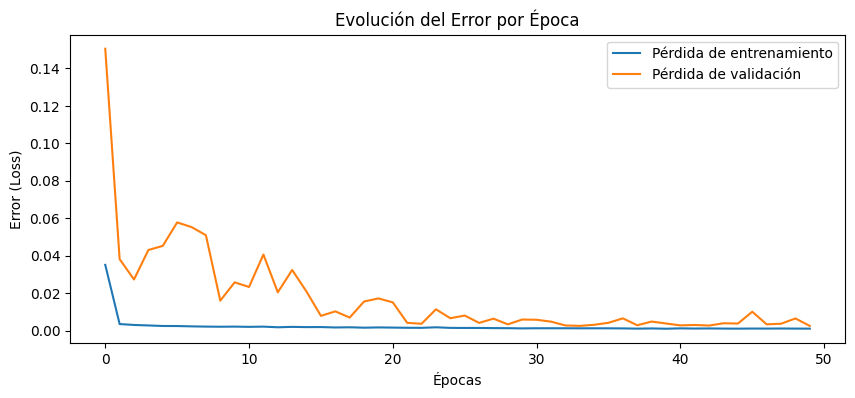

In [48]:
# Extraer la pérdida de entrenamiento y validación
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Crear la figura del gráfico
plt.figure(figsize=(10, 4))

# Graficar la pérdida de entrenamiento
plt.plot(loss, label="Pérdida de entrenamiento")

# Graficar la pérdida de validación
plt.plot(val_loss, label="Pérdida de validación")

# Configurar títulos y etiquetas
plt.title("Evolución del Error por Época")
plt.xlabel("Épocas")
plt.ylabel("Error (Loss)")
plt.legend()

# Mostrar el gráfico
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Error Cuadrático Medio (MSE): 35.0531
Raiz del Error Cuadrático Medio (RMSE): 5.9206
Error Absoluto Medio (MAE): 4.4718


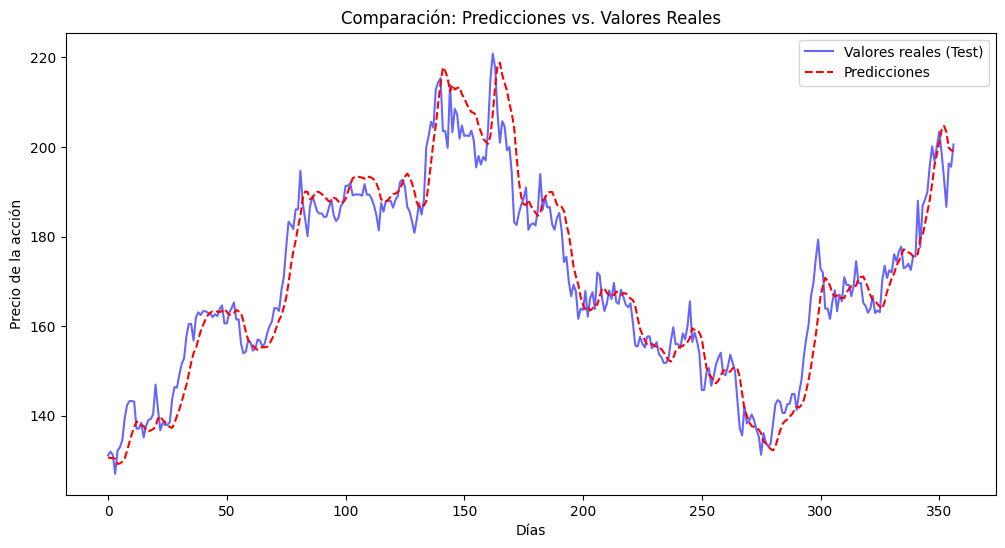

In [49]:
# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Si escalaste los datos, invierte la transformación para obtener valores reales
# (Asumiendo que usaste MinMaxScaler y lo guardaste en 'scaler')
y_pred_real = scaler.inverse_transform(y_pred)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))  # Asegurar misma forma

# Calcular MSE y MAE

mse_lstm = mean_squared_error(y_test_real, y_pred_real)
rmse_lstm = (mse_lstm)**(0.5)
mae_lstm = mean_absolute_error(y_test_real, y_pred_real)

print(f'Error Cuadrático Medio (MSE): {mse_lstm:.4f}')
print(f'Raiz del Error Cuadrático Medio (RMSE): {rmse_lstm:.4f}')
print(f'Error Absoluto Medio (MAE): {mae_lstm:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='Valores reales (Test)', color='blue', alpha=0.6)
plt.plot(y_pred_real, label='Predicciones', color='red', linestyle='--')
plt.title('Comparación: Predicciones vs. Valores Reales')
plt.xlabel('Días')
plt.ylabel('Precio de la acción')
plt.legend()
plt.show()

## Mejorando el modelo LSTM con validación cruzada y gridSerch

In [50]:
import os
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization


# Importar KerasRegressor desde scikeras
from scikeras.wrappers import KerasRegressor

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

# === 1. Asegúrate de tener definidos X_train, y_train con la forma (samples, timesteps, features) ===
# Por ejemplo, X_train.shape -> (2112, 20, 1)

# === 2. Definir la función que crea el modelo ===
def create_model(neurons=50, dropout_rate=0.2, lr=0.001):
    model = Sequential()
    model.add(LSTM(neurons, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), recurrent_dropout= 0.2))
    model.add(BatchNormalization())   # Normalización después de la LSTM
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse')
    return model

# === 3. Crear el KerasRegressor usando scikeras ===
keras_reg = KerasRegressor(model=create_model, verbose=0, random_state=42)

# === 4. Definir la métrica a optimizar (MSE) ===
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# === 5. Definir la rejilla de hiperparámetros ===
param_grid = {
    'model__neurons': [50, 64, 100],
    'model__dropout_rate': [0.2, 0.3, 0.4],
    'batch_size': [16, 32],
    'epochs': [10, 20, 30, 50],
    'model__lr': [0.001, 0.0005]  # Opcional
}

# === 6. Definir el validador para series de tiempo ===
tscv = TimeSeriesSplit(n_splits=3)

# === 7. Configurar GridSearchCV con el validador de series de tiempo ===
grid = GridSearchCV(
    estimator=keras_reg,
    param_grid=param_grid,
    scoring=mse_scorer,
    cv=tscv,
    n_jobs=-1
)

# Configurar grid search (suponiendo que 'grid' ya esté definido)
results_filename = 'grid_search_results.pkl'

if os.path.exists(results_filename):
    print("Cargando resultados del grid search desde archivo...")
    grid_result = joblib.load(results_filename)
else:
    print("Ejecutando grid search...")
    grid_result = grid.fit(X_train, y_train)
    joblib.dump(grid_result, results_filename)
    print("Resultados guardados en", results_filename)

# === 9. Imprimir los mejores resultados ===
print("Mejores parámetros:", grid_result.best_params_)
print("Mejor puntuación (MSE negativo):", grid_result.best_score_)

# === 10. Obtener el mejor modelo y evaluarlo en el conjunto de prueba ===
best_model = grid_result.best_estimator_.model_
y_pred_test = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
print("MSE en el conjunto de prueba:", mse_test)


Cargando resultados del grid search desde archivo...
Mejores parámetros: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.3, 'model__lr': 0.0005, 'model__neurons': 100}
Mejor puntuación (MSE negativo): -0.0005462990562513352
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MSE en el conjunto de prueba: 0.0040626720010323285


In [51]:
#Mejores parámetros: {'batch_size': 16, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__neurons': 64}
#Mejor puntuación (MSE negativo): -0.00034578389933952153
#[1m12/12[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 20ms/step
#MSE en el conjunto de prueba: 0.0026653185314592215
print("Resultado de la primera optimización optimización")

Resultado de la primera optimización optimización


Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.3962 - val_loss: 0.8960
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0850 - val_loss: 0.8266
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0493 - val_loss: 0.8053
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0364 - val_loss: 0.8570
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0221 - val_loss: 0.7230
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0158 - val_loss: 0.6329
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0126 - val_loss: 0.5290
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0093 - val_loss: 0.4052
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0076 - val_loss: 0.2845
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0069 - val_loss: 0.1240
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0064 - val_loss: 0.0718
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0

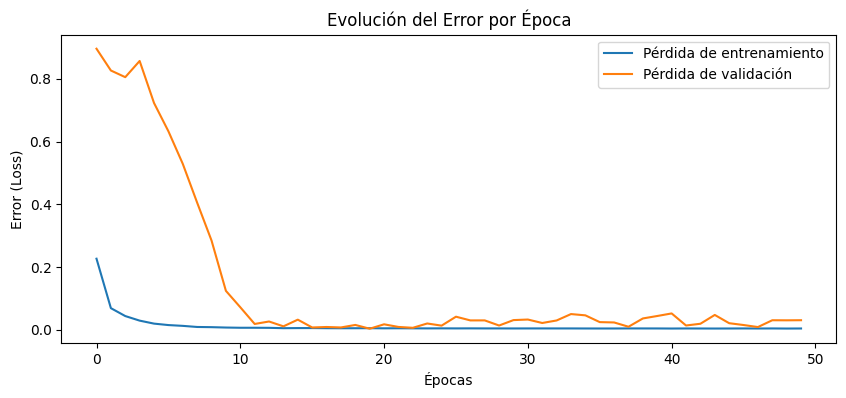

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MSE en test: 409.82758054145984
RMSE en test: 20.244198688549268
MAE en test: 16.01302512887479


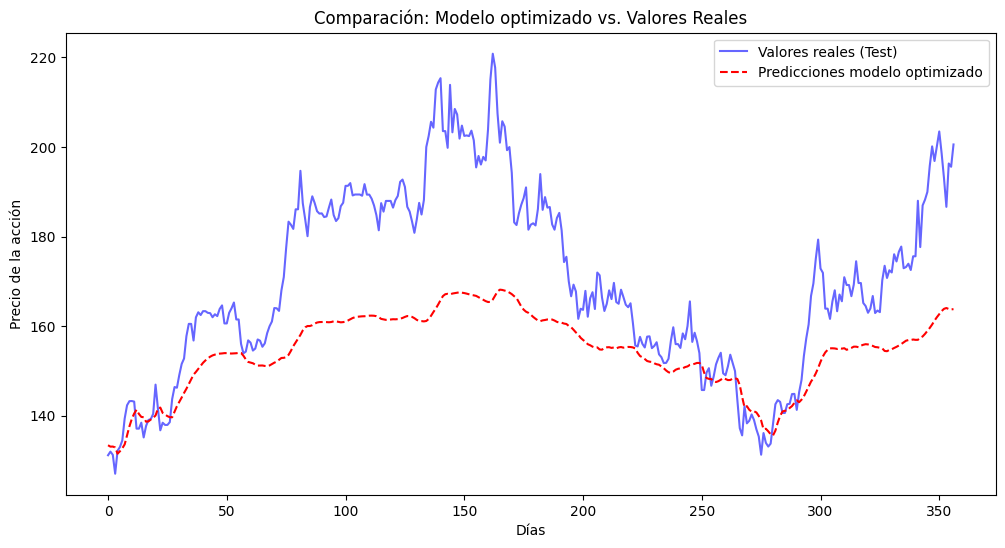

In [52]:
# 1. Usar los mejores hiperparámetros obtenidos
best_neurons = 100
best_dropout = 0.3
best_epochs = 50
best_batch_size = 32
best_lr = 0.0005 

# 2. Crear el modelo final
final_model = create_model(neurons=best_neurons, dropout_rate=best_dropout, lr=best_lr)

# 3. Entrenar el modelo final con todo el conjunto de entrenamiento
history_2 = final_model.fit(
    X_train, y_train,
    epochs=best_epochs,
    batch_size=best_batch_size,
    validation_data=(X_test, y_test),
    verbose=1
)

# 3.1 Gráficar el comportamiento de pérdida
# Extraer la pérdida de entrenamiento y validación
loss_2 = history_2.history["loss"]
val_loss_2 = history_2.history["val_loss"]

# Crear la figura del gráfico
plt.figure(figsize=(10, 4))

# Graficar la pérdida de entrenamiento
plt.plot(loss_2, label="Pérdida de entrenamiento")

# Graficar la pérdida de validación
plt.plot(val_loss_2, label="Pérdida de validación")

# Configurar títulos y etiquetas
plt.title("Evolución del Error por Época")
plt.xlabel("Épocas")
plt.ylabel("Error (Loss)")
plt.legend()

# Mostrar el gráfico
plt.show()


# 4. Realizar predicciones en el conjunto de prueba (en la escala transformada)
y_pred_scaled_2 = final_model.predict(X_test)

# 5. Revertir la transformación para obtener los valores reales
# Se asume que 'scaler' es el objeto MinMaxScaler utilizado previamente
y_pred_real_2 = scaler.inverse_transform(y_pred_scaled_2)
y_test_real_2 = scaler.inverse_transform(y_test.reshape(-1, 1))

# 6. Calcular métricas de desempeño con los valores reales
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse_final = mean_squared_error(y_test_real_2, y_pred_real_2)
rmse_final = mse_final ** 0.5
mae_final = mean_absolute_error(y_test_real_2, y_pred_real_2)

print("MSE en test:", mse_final)
print("RMSE en test:", rmse_final)
print("MAE en test:", mae_final)

plt.figure(figsize=(12, 6))
plt.plot(y_test_real_2, label='Valores reales (Test)', color='blue', alpha=0.6)
plt.plot(y_pred_real_2, label='Predicciones modelo optimizado', color='red', linestyle='--')
plt.title('Comparación: Modelo optimizado vs. Valores Reales')
plt.xlabel('Días')
plt.ylabel('Precio de la acción')
plt.legend()
plt.show()

### Comparación de modelos no optimizado y optimizado

,modelo no optimizado,modelo optimizado
MSE,35.053061,409.827581
RMSE,5.920563,20.244199
MAE,4.471839,16.013025


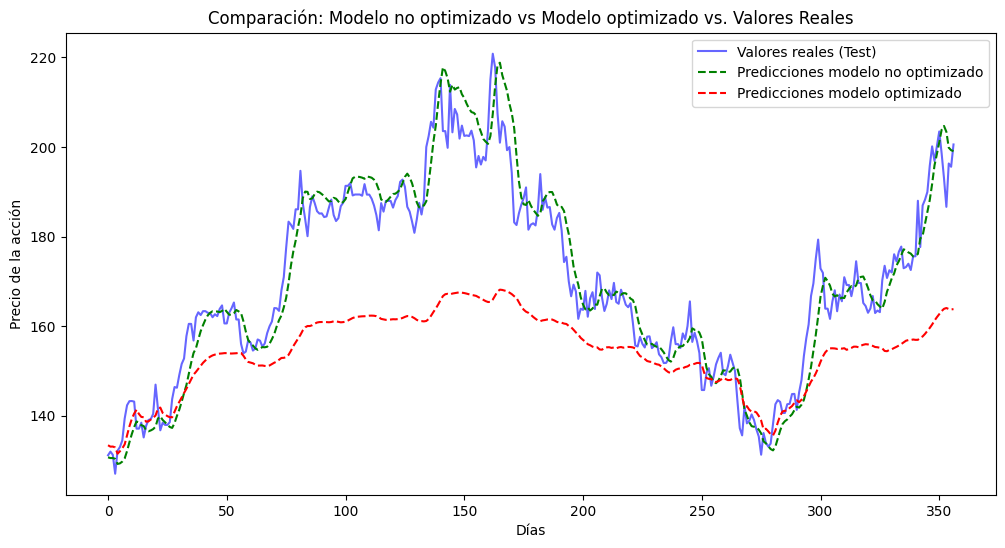

In [53]:
A = pd.DataFrame(data= {"modelo no optimizado":[mse_lstm, rmse_lstm, mae_lstm], "modelo optimizado": [mse_final, rmse_final, mae_final]}, index= ["MSE", "RMSE", "MAE"])

display(A)
plt.figure(figsize=(12, 6))
plt.plot(y_test_real_2, label='Valores reales (Test)', color='blue', alpha=0.6)
plt.plot(y_pred_real, label='Predicciones modelo no optimizado', color='green', linestyle='--')
plt.plot(y_pred_real_2, label='Predicciones modelo optimizado', color='red', linestyle='--')
plt.title('Comparación: Modelo no optimizado vs Modelo optimizado vs. Valores Reales')
plt.xlabel('Días')
plt.ylabel('Precio de la acción')
plt.legend()
plt.show()


**Conclusión**:

El modelo no optimizado tuvo mejores rendimientos con respecto a nuestras métricas. 

Explorar otras arquitecturas o complejidades:

* Aumentar la profundidad: Probar modelos con más de una capa LSTM (por ejemplo, apilando dos capas) y ajustar el número de neuronas en cada una.

* Regularización adicional: Además del dropout, puedes considerar agregar recurrent dropout en la capa LSTM o usar Batch Normalization.

* Cambiar la función de activación: Experimentar con activaciones como "tanh" en lugar de "relu" para ver si se adaptan mejor a la serie de tiempo.

### Predicción recursiva sin datos previos de nuestro conjunto test

¿Cómo adaptar tu LSTM para emular a Prophet?

Para que tu LSTM haga predicciones multi-paso sin depender de datos reales (solo usando sus propias predicciones), debes implementar un bucle recursivo:

In [54]:
def predict_multistep_lstm(model, initial_sequence, steps):
    predictions = []
    current_sequence = initial_sequence.copy()  # Ej: últimos 20 días de X_train
    for _ in range(steps):
        next_pred = model.predict(current_sequence.reshape(1, 20, 1))[0, 0]
        predictions.append(next_pred)
        current_sequence = np.roll(current_sequence, -1)  # Desplaza la ventana
        current_sequence[-1] = next_pred  # Agrega la predicción
    return np.array(predictions)  # Convertir a array NumPy aquí

# 1. Generar predicciones multi-paso
initial_window = X_train[-1]  # Última ventana del entrenamiento
scaled_predictions = predict_multistep_lstm(model, initial_window, steps=len(scaled_precios_test))

print(scaled_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

MSE: 10193.9007
RMSE: 100.9648
MAE: 94.3779


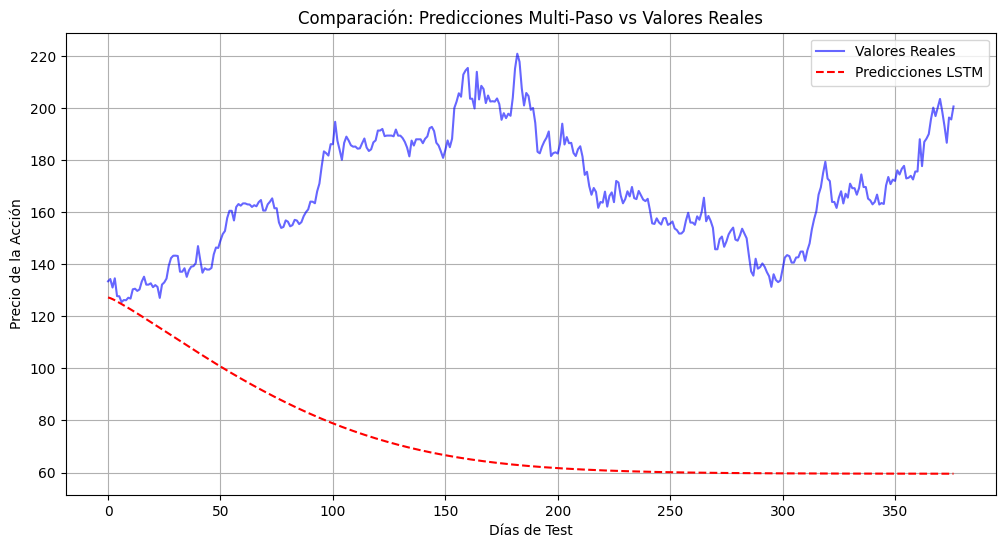

In [55]:
# 2. Invertir la transformación
# Para las predicciones
scaled_predictions_2d = scaled_predictions.reshape(-1, 1)
predictions_real_multistep = scaler.inverse_transform(scaled_predictions_2d).flatten()

# Para los datos de test
scaled_test_2d = scaled_precios_test.reshape(-1, 1)
test_real = scaler.inverse_transform(scaled_test_2d).flatten()

# 3. Calcular métricas
mse_lstm_multistep = mean_squared_error(test_real, predictions_real_multistep)
rmse_lstm_multistep = np.sqrt(mse_lstm_multistep)
mae_lstm_multistep = mean_absolute_error(test_real, predictions_real_multistep)

print(f'MSE: {mse_lstm_multistep:.4f}')
print(f'RMSE: {rmse_lstm_multistep:.4f}')
print(f'MAE: {mae_lstm_multistep:.4f}')

# 4. Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(test_real, label='Valores Reales', color='blue', alpha=0.6)
plt.plot(predictions_real_multistep, label='Predicciones LSTM', color='red', linestyle='--')
plt.title('Comparación: Predicciones Multi-Paso vs Valores Reales')
plt.xlabel('Días de Test')
plt.ylabel('Precio de la Acción')
plt.legend()
plt.grid(True)
plt.show()

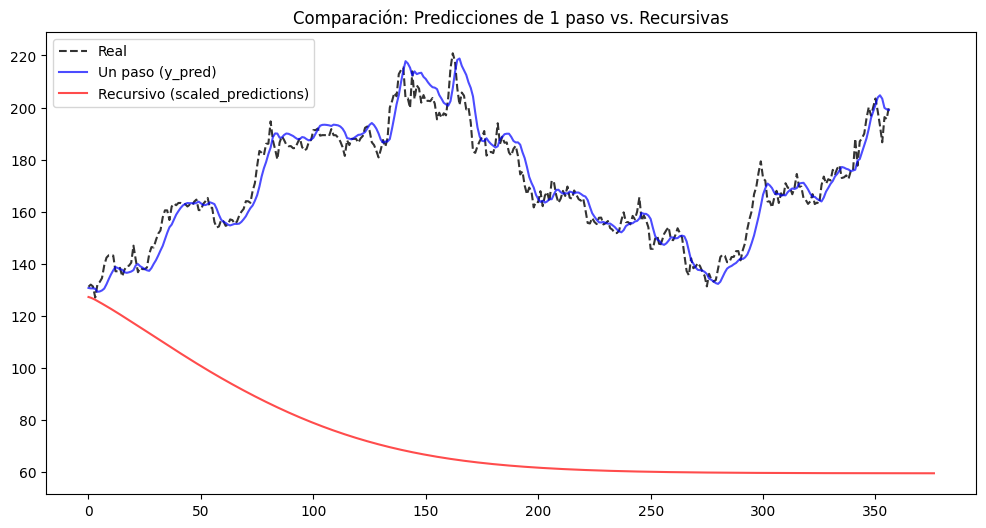

In [56]:
# Graficar
plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='Real', color='black', linestyle='--', alpha=0.8)
plt.plot(y_pred_real, label='Un paso (y_pred)', color='blue', alpha=0.7)
plt.plot(predictions_real_multistep, label='Recursivo (scaled_predictions)', color='red', alpha=0.7)
plt.legend()
plt.title('Comparación: Predicciones de 1 paso vs. Recursivas')
plt.show()

**Observaciones**:

En la primera predicción toma en cuenta los primeros 20 datos del conjunto de test para iniciar las predicciones y el modo de predicción recursivo sólo toma los datos de entrenamiento. Al querer ajustar las prediciciones al mismo punto inical que sería los primeros 20 días del conjunto de test las predicciones se disparan en el modo recursivo.

El problema se debe a que, en la predicción recursiva, los errores se acumulan y la ventana inicial influye en la estabilidad de las predicciones futuras. Algunas sugerencias para solucionarlo son:

Ventana inicial adecuada:
Cuando usas la ventana de entrenamiento (último X_train) como semilla, el modelo está en una región de la distribución en la que se entrenó, lo que reduce la acumulación de errores. En cambio, al usar el primer X_test se puede introducir una transición o cambio en la distribución que el modelo no ha visto durante el entrenamiento, lo que provoca que los errores se amplifiquen con cada paso.

Predicción directa multi-paso:
Una alternativa es entrenar el modelo para predecir varios pasos de una sola vez (en vez de recursivamente) o aplicar técnicas de teacher forcing durante el entrenamiento para que aprenda a corregir sus propios errores en la secuencia generada.

Verificar la escala y la consistencia:
Asegúrate de que los datos escalados y su inversa (con el mismo scaler) sean consistentes. Un desajuste en el escalado o en el rango de los datos puede contribuir a que se dispare la magnitud de las predicciones.

En resumen, la estabilidad de la predicción recursiva depende fuertemente de la ventana inicial. Si la ventana inicial proviene de un dominio diferente al de entrenamiento (o está en una zona de transición), los errores se amplifican y se pueden obtener valores absurdos (inf/nan). Para mejorar esto, utiliza una ventana inicial que provenga de la misma distribución de entrenamiento o emplea estrategias que reduzcan la acumulación de error.

